In [0]:
import os
from fastai import *
from fastai.tabular import *
import pandas as pd
from sklearn.model_selection import  StratifiedKFold

# **Data Loading**

In order to use the free GPU provided by google, we have decided to run the experiment on google colaboratory (google colab). One way to access your data on google colab is to upload the data to your google drive, and subsequently mount your drive on to the workspace.

Put the file you downloaded from Kaggle into a directory called **data** in your google drive. It is worth mentioning that the root directory in google drive is denoted by **My Drive** (as two separate words).

In [2]:
#Google drive will be mounted, this will require permission from google account
from google.colab import drive
drive.mount('/mnt')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /mnt


In [0]:
#it is assumed that your google drive has a directory "data" which contains the dataset "train_2v.csv"
path = '/mnt/My Drive/data'

In [0]:
#read the csv file into a variable "train_df"
train_df = pd.read_csv(os.path.join(path,'train_2v.csv'))

# **Data Analysis/Exploration**

We will use pandas to explore the loaded csv file. First we will start by checking the data type for each variable, this will help us to determine if a particular variable is discrete (categorical) or continous. It is also important to identify columns with missing data, as well as the cardinality of the categorical variables

In [5]:
#use info() to explore variable data types, it also tells us the total number of records
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [6]:
#use isnull() and unique() to count missing fields, and cardinality respectively
space_len = 20
print('Variable\t\tMissing Fields\t\tCardinality\t\tValues')
for col in train_df:
  missing_count = train_df[col].isnull().sum()
  vals    = train_df[col].unique()
  card_count = len(vals)
  print(''.join(col.ljust(space_len))+'\t'+''.join(str(missing_count).ljust(space_len))+'\t'+''.join(str(card_count).ljust(space_len))+'\t'+''+str(vals))
  

Variable		Missing Fields		Cardinality		Values
id                  	0                   	43400               	[30669 30468 16523 56543 ...  5450 28375 27973 36271]
gender              	0                   	3                   	['Male' 'Female' 'Other']
age                 	0                   	104                 	[ 3.   58.    8.   70.   ...  0.56  0.48  1.32  0.16]
hypertension        	0                   	2                   	[0 1]
heart_disease       	0                   	2                   	[0 1]
ever_married        	0                   	2                   	['No' 'Yes']
work_type           	0                   	5                   	['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
Residence_type      	0                   	2                   	['Rural' 'Urban']
avg_glucose_level   	0                   	12543               	[ 95.12  87.96 110.89  69.04 ... 248.93 182.45 121.45 132.22]
bmi                 	1462                	556                 	[18.  39.2 17.6 35.9

In [8]:
#we may as well have a glimpse at top few rows of the data
train_df.head().T

,0,1,2,3,4
id,30669,30468,16523,56543,46136
gender,Male,Male,Female,Female,Male
age,3,58,8,70,14
hypertension,0,1,0,0,0
heart_disease,0,0,0,0,0
ever_married,No,Yes,No,Yes,No
work_type,children,Private,Private,Private,Never_worked
Residence_type,Rural,Urban,Urban,Rural,Rural
avg_glucose_level,95.12,87.96,110.89,69.04,161.28
bmi,18,39.2,17.6,35.9,19.1


# **Data Pre-processing**

We assume that **Id** is just an identifier that has no much relavant information. Hence we can convineintly drop that column and work with the rest of the data. Fastai handles data preprocessing steps, such as filling missing values, normalization of continous variables and serialization of categorical variables. All we need to do is to create two lists one to denote continuous variables and the other to denote categorical variables. Furthermore, we have to identify the dependent variable; they will be used to create a Fastai Databunch just before training.

In [0]:
#we will drop the ids column
train_df = train_df.drop(['id'], axis=1)

In [0]:
#form a list of continuous and categorical data and the dependent variable
data_cont_vars = ['age', 'avg_glucose_level', 'bmi']
data_cat_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

dep_var = 'stroke'

In [0]:
procs = [FillMissing, Categorify, Normalize] # define processing steps that will be applied when creating training and validation data

# **Model Training**

Fastai provides us with a convinient way of reading our data, creating a model and conducting training conviniently with just a few lines of code. Of course it is quite important to know what is happening behind the scenes. 

Basically, this involves the following steps:

 

1.   Use sklearn to get indices of training and validation data

2.   for each fold we will create a databunch, that is a simply preparing the data we will be using for training; the preprocessing steps mentioned in our report will be applied during this stage. 


3.   Use Fastai's **tabular_learne**r function to create the model, this will create embedding layers for each of the categorical data, then the continous variables will be batch normalised and concatenated to the output of the embeddings. Finally, the concatenated features are fed into two fully connected layers whose dimension is defined by tabular_learner's **layers** argument. **ps** argument defines keep_prob value for drop-out that is applied to the two fully connected layers, and prior to that the **emb_drop** argument is used to apply drop-out to embeddings; these are used to avoid over-fitting. 

4. For the embeding size, Fastai uses a heuristic given by 
`min(600, round(1.6 * n_cat**0.56))`
where `n_cat` is the cardinality for each categorical variable. We have decided to stick with this values in this work. 

5. To choose the best learning rate using the learning rate finder, we will plot with Fastai's **recorder.plot()** function and then choose learning rate that corresponds to point where the loss is decreasing fastest

6. Fastai's **fit_one_cycle** function is used to train the model. This uses Leslie Smith's famous one cycle policy. Research has shown the technique to be efficient, thus producing faster convergence as well as more accurate results. The two arguments we pass to the function are number of epochs, and the learning rate. 







In [0]:
#we will use StratifiedKFold from sklearn to get train and validation indices 
kflds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

#we will use a batch size of 64 for our model
bs =64

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


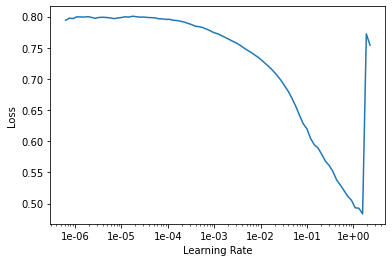

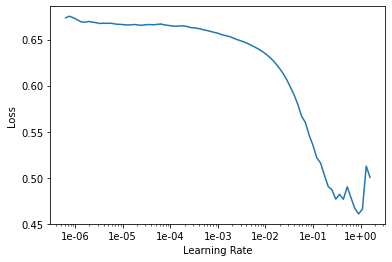

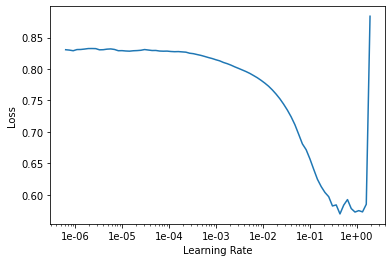

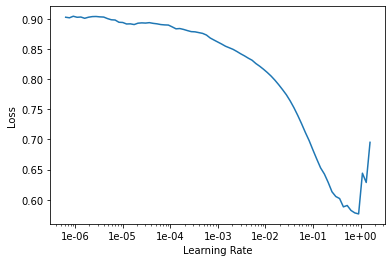

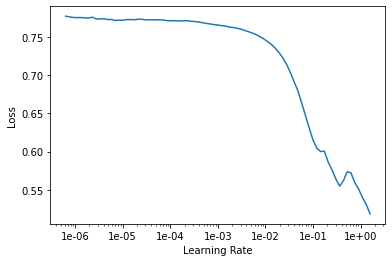

In [17]:
#here we will iterate through each of the kfolds (5 folds) and use learning rate finder function (provided by Fastai) to choose the best learning rate for training 
#obviously this is the same pipeline that we will be using for the training
tf = train_df[data_cat_vars + data_cont_vars + [dep_var]].copy()
for train_idx, valid_idx in kflds.split(train_df.index, train_df['stroke']):
  #create databunch
  data_fold = (TabularList.from_df(tf, path=path, cat_names=data_cat_vars, cont_names=data_cont_vars, procs=procs)
            .split_by_idxs(train_idx, valid_idx)
            .label_from_df(cols=dep_var)
            .databunch(bs=bs)

        )
  #create the model, the number of layers, as well as drop-out parameters were choosen emperically
  learn = tabular_learner(data_fold, layers=[56, 28], ps=[0.001, 0.01], emb_drop=0.04, metrics=accuracy)
  learn.lr_find() #find the 
  learn.recorder.plot()

In [0]:
#looking at all five plots, we can conveniently choose a learning rate of 1e-2
lr = 1e-2*5


In [19]:
#we can also plot the model to see the architecture
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(6, 4)
    (5): Embedding(3, 3)
    (6): Embedding(4, 3)
    (7): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=28, out_features=56, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=56, out_features=28, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=28, out_features=2, bias=True)
  )
)

In [0]:
#we can now perform the training by calling the fit_one_cycle function
# form a list of continuous and categorical data and the dependent variable
data_cont_vars = ['age', 'avg_glucose_level', 'bmi']
data_cat_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
dep_var = 'stroke'
overall_acc = []
y_range = torch
tf = train_df[data_cat_vars + data_cont_vars + [dep_var]].copy()
X = train_df.drop(['stroke'], axis=1)
y = train_df['stroke']
for train_idx, valid_idx in kflds.split(X, y):
  data_fold = (TabularList.from_df(tf, path=path, cat_names=data_cat_vars, cont_names=data_cont_vars, procs=procs)
            .split_by_idx(valid_idx)
            .label_from_df(cols=dep_var)
            .databunch(bs=32)

        )
    
  learn = tabular_learner(data_fold, layers=[56, 28], ps=[0.001, 0.01], emb_drop=0.04, metrics=accuracy)
  learn.fit_one_cycle(5, max_lr=lr)
  loss,acc = learn.validate()
  overall_acc.append(acc.numpy())
  
print('\n Mean accuracy after 5 folds is {}%'.format(round(np.mean(overall_acc)*100, 2)))

epoch,train_loss,valid_loss,accuracy,time
0,0.084473,0.075424,0.982028,00:09
1,0.079700,0.076519,0.981452,00:09
2,0.071756,0.075208,0.982028,00:09
3,0.075519,0.073800,0.982028,00:09
4,0.080040,0.073176,0.982028,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.078491,0.075296,0.981912,00:08
1,0.087047,0.083338,0.982028,00:09
2,0.084467,0.098414,0.981336,00:09
3,0.077278,0.072772,0.982028,00:08
4,0.062812,0.072800,0.982028,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.082068,0.079197,0.981336,00:09
1,0.086586,0.075105,0.981912,00:09
2,0.089592,0.133129,0.981912,00:09
3,0.087516,0.074360,0.981912,00:08
4,0.078246,0.072970,0.981912,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.086895,0.095013,0.977074,00:09
1,0.072575,0.079917,0.981912,00:09
2,0.076891,0.083035,0.981452,00:09
3,0.084701,0.074472,0.981912,00:09
